# Propensity Score Matching

Propensity Score Matching `PSM` is an approach for causal inference. In particular, PSM is used to estimate the Average Treatment Effect `ATE` one variable, termed the treatment variable `T`, on another, termed the outcome variable `O`. In general, `T` and `O` are pairs that are assumed to be in a causal relationship, where manipulating `T` changes `O`. However, how `T` impacts `O` in magnitude and direction is usually confounded by many variables $X = {X_1, X_2, \ldots, X_n}$. For example, if `T` represents the application of a novel surgical procedure used for a certain disease, then `T=1` denotes the use of such procedure and `T=0` denotes the non-use of such procedure. The outcome `O` could be that the patient has been cured `O=1` or not `O=0`. What we want to do is to estimate how `T` impacts `O`, and one way to do so is to simply taken the differences of the expected values of the outcomes when treatment is applied or not.

- $\mathrm{ATE} = E[O|T=1] - E[O|T=0]$

The problem is with confounding variables; it could be that healthier patients are biasedly selected into treatment `T=1` and less healthy patients are selected into non-treatment `T=0`. If we were to estimate `ATE`, then the result would be biased. 

Before we compute `ATE`, we should remove confounding variables, and PSM is one way to do so by introducing a propensity score which balances the data/covariates (balancing means removing confounding variables). The propensity score of an item (e.g. a patient) is simply its probability of being assigned to treatment `T=1`. Commonly, the propensity score of an item is produced through logistic regression, where `T` is the dependent variable and $X$ are the independent variables. Once every item has a propensity score, then paired samples from the population where `T=0` and `T=1` can be created based on their propensity scores (you want to create a pair of samples such that their propensity scores are nearly, if not entirely, identical). This approach makes sense since we are essentially pairing up items that are identical in every way except for whether or not they were treated; that the items in a pair are identical in every way is the removal of confounding variables/factors. This approach addresses the [Fundamental Problem of Causal Inference](https://en.wikipedia.org/wiki/Rubin_causal_model#The_fundamental_problem_of_causal_inference) `FPCI`. Without going into depth, after we have a pairing of individuals (one treated with one that is not treated), then we can compute the `ATE`. 

There are many ways to conduct PSM, but in this notebook, use double regression to estimate ATE. Denote the following.

- T is the treatment variable
- O is the outcome variable
- X is the set of covariates (possibly confounding variables)

Then the procedure is as follows.

- Use logistic regression `T ~ X` to assign a propensity score $\pi_i$ on each item
- Calculate the Inverse Probability Treatment Weight `IPTW` from the propensity score and T
  - $w_i = \dfrac{T_i}{\pi_i} + \dfrac{1 - T_i}{1 - \pi_i}$
- Conduct weighted regression `O ~ T + X` using $w$

The coefficient associated with `T` will be the ATE.

## Data

The data is taken from [Causal Analysis and Comparative Effectiveness Course](http://openonlinecourses.com/causalanalysis/Propensity%20Scoring.asp). There are 6,657 patients 9 covariates indicating the presence (1) or absence (0) of a disease.

- hypertension
- anemia
- diabetes
- hiv
- stomach cancer
- lung cancer
- myocardial infarction
- heart failure
- metastatic cancer

The treatment variable `T` denotes whether a patient was treated by Dr. Smith.

- 1 indicates a patient was treated by Dr. Smith
- 0 indicates a patient was `not` treated by Dr. Smith

The outcome variable `O` denotes the length of stay (LOS) of each patient. 

We want to estimate the [average treatment effect (ATE)](https://en.wikipedia.org/wiki/Average_treatment_effect) of Dr. Smith on the LOS. 

In [1]:
import pandas as pd

df = pd.read_csv('./psm-data.csv')
df.shape

(6657, 11)

In [2]:
df.head()

,hypertension,anemia,diabetes,hiv,stomach_cancer,lung_cancer,myocardial_infarction,heart_failure,metastetic_cancer,T,O
0,0,0,0,0,0,0,0,0,0,0,3
1,1,0,0,0,0,0,0,0,0,0,4
2,0,0,0,0,0,0,0,0,0,1,6
3,1,0,0,0,0,0,0,0,0,1,6
4,0,1,0,0,0,0,0,0,0,0,3


## Visualization

### Overall disease proportions

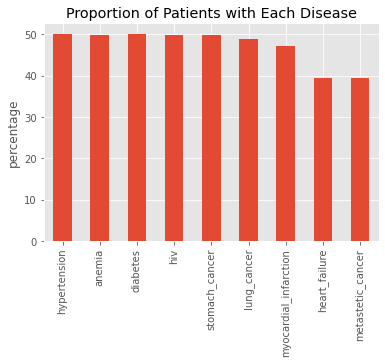

In [3]:
import matplotlib.pyplot as plt

plt.style.use('ggplot')

X_cols = [c for c in df.columns if c not in {'T', 'O'}]

s = df[X_cols].sum() / df.shape[0] * 100.0
_ = s.plot(kind='bar', title='Proportion of Patients with Each Disease', ylabel='percentage')

### Treatment percentage

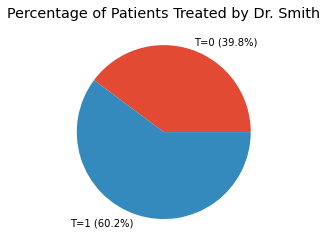

In [4]:
s = df['T'].value_counts().sort_index() / df['T'].value_counts().sum() * 100.0
s.index = [f'T={i} ({v:.1f}%)' for i, v in zip(s.index, s.values)]
_ = s.plot(kind='pie', title='Percentage of Patients Treated by Dr. Smith', ylabel='')

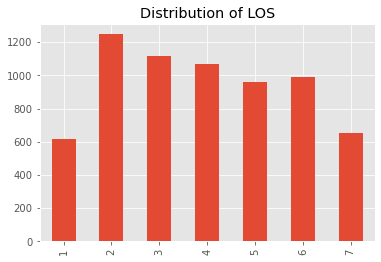

In [5]:
_ = df['O'].value_counts().sort_index().plot(kind='bar', title='Distribution of LOS')

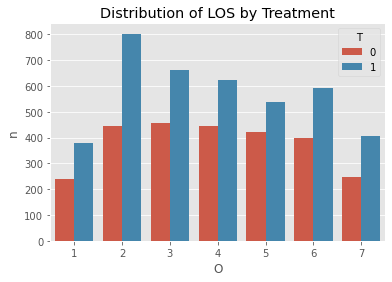

In [6]:
import seaborn as sns

s = df[['T', 'O', 'hiv']].groupby(['T', 'O']).agg('count').reset_index().rename(columns={'hiv': 'n'})

ax = sns.barplot(x='O', y='n', hue='T', data=s)
_ = ax.set_title('Distribution of LOS by Treatment')

### Proportions by disease and treatment

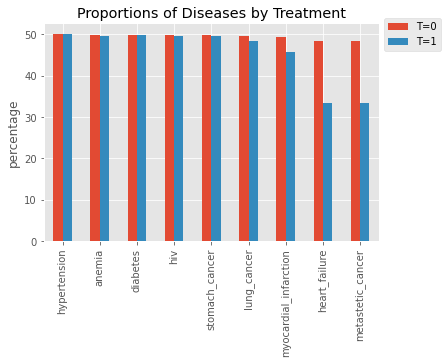

In [7]:
s0 = df[df['T'] == 0][X_cols].sum() / df[df['T'] == 0][X_cols].shape[0] * 100.0
s1 = df[df['T'] == 1][X_cols].sum() / df[df['T'] == 1][X_cols].shape[0] * 100.0

ax = pd.DataFrame({'T=0': s0, 'T=1': s1}).plot(kind='bar', title='Proportions of Diseases by Treatment', ylabel='percentage')
_ = ax.legend(bbox_to_anchor=(1.0, 1.05))

### Two-proportion z-test

We perform a [two-proportion z-test](https://en.wikipedia.org/wiki/Test_statistic) to see if there is any difference in the proportions by treatment.

In [8]:
from statsmodels.stats.proportion import proportions_ztest

count_df = pd.DataFrame({'T=0': df[df['T'] == 0][X_cols].sum(), 'T=1': df[df['T'] == 1][X_cols].sum()})
n = {
    0: df[df['T'] == 0][X_cols].shape[0],
    1: df[df['T'] == 1][X_cols].shape[0]
}

ztest_df = pd.DataFrame([(i,) + proportions_ztest(count=[r['T=0'], r['T=1']], nobs=[n[0], n[1]], alternative='two-sided') 
                         for i, r in count_df.iterrows()], columns=['variable', 'stats', 'p_value'])
ztest_df['p < 0.01'] = ztest_df['p_value'].apply(lambda p: p < 0.01)
ztest_df

,variable,stats,p_value,p < 0.01
0,hypertension,-0.109640,9.126952e-01,False
1,anemia,0.238975,8.111251e-01,False
2,diabetes,0.019694,9.842877e-01,False
3,hiv,0.158755,8.738619e-01,False
4,stomach_cancer,0.158755,8.738619e-01,False
5,lung_cancer,0.794437,4.269413e-01,False
6,myocardial_infarction,2.890758,3.843136e-03,True
7,heart_failure,12.233395,2.061393e-34,True
8,metastetic_cancer,12.233395,2.061393e-34,True


## Propensity Score

In [9]:
from sklearn.linear_model import LogisticRegression

X = df[df.columns.drop(['O', 'T'])]
y = df['T']

model = LogisticRegression(random_state=37)
model.fit(X, y)

LogisticRegression(random_state=37)

In [10]:
psm_df = pd.DataFrame({
    'T': y,
    'propensity_score': model.predict_proba(X)[:,1]
})
psm_df['inverse_weight'] = psm_df.apply(lambda r: 1 / r['propensity_score'] if r['T'] == 1 else 1 / (1 - r['propensity_score']), axis=1)
psm_df['sampling_weight'] = psm_df['inverse_weight'] / psm_df['inverse_weight'].sum()

In [11]:
psm_df.head()

,T,propensity_score,inverse_weight,sampling_weight
0,0,0.706267,3.404448,0.000256
1,0,0.707120,3.414373,0.000257
2,1,0.706267,1.415896,0.000107
3,1,0.707120,1.414186,0.000106
4,0,0.704355,3.382430,0.000254


Check that the weights can reconstruct the original population.

In [12]:
psm_df.shape[0], psm_df[psm_df['T'] == 0].inverse_weight.sum(), psm_df[psm_df['T'] == 1].inverse_weight.sum()

(6657, 6614.186072184293, 6678.808997206876)

Check for evidence of confounding. 

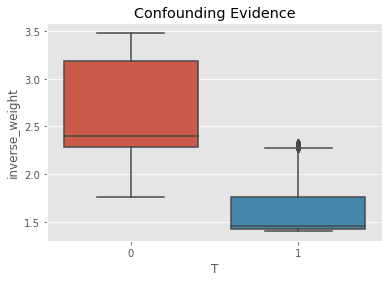

In [13]:
ax = sns.boxplot(x='T', y='inverse_weight', data=psm_df)
_ = ax.set_title('Confounding Evidence')

The positivity check ensures that there is overlap between the treatment and non-treatment groups.

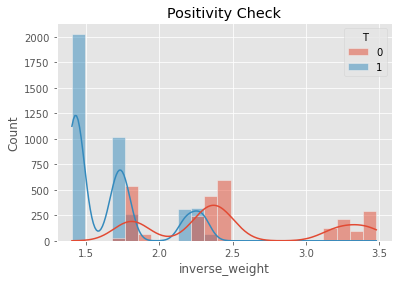

In [14]:
ax = sns.histplot(data=psm_df, x='inverse_weight', hue='T', kde=True)
_ = ax.set_title('Positivity Check')

We can check to see if the covariates are balanced by conducting two-sample z-test over each variable.

In [15]:
weighted_df = df.sample(frac=1, weights=psm_df.inverse_weight, replace=True).drop(columns=['O'])
weighted_df.shape

(6657, 10)

In [16]:
cols = weighted_df.columns.drop(['T'])
count_df = pd.DataFrame({'T=0': weighted_df[weighted_df['T'] == 0][cols].sum(), 'T=1': weighted_df[weighted_df['T'] == 1][cols].sum()})
n = {
    0: weighted_df[weighted_df['T'] == 0][cols].shape[0],
    1: weighted_df[weighted_df['T'] == 1][cols].shape[0]
}

ztest_df = pd.DataFrame([(i,) + proportions_ztest(count=[r['T=0'], r['T=1']], nobs=[n[0], n[1]], alternative='two-sided') 
                         for i, r in count_df.iterrows()], columns=['variable', 'stats', 'p_value'])
ztest_df['p < 0.01'] = ztest_df['p_value'].apply(lambda p: p < 0.01)
ztest_df

,variable,stats,p_value,p < 0.01
0,hypertension,1.130927,0.258086,False
1,anemia,0.900596,0.367803,False
2,diabetes,-1.017216,0.309051,False
3,hiv,0.263115,0.792462,False
4,stomach_cancer,1.495739,0.134722,False
5,lung_cancer,0.156585,0.875572,False
6,myocardial_infarction,-0.548840,0.583115,False
7,heart_failure,0.473499,0.635857,False
8,metastetic_cancer,0.027691,0.977908,False


## Average Treatment Effect

The ATE of Dr. Smith on LOS is a reduction of 0.06 days.

In [17]:
from sklearn.linear_model import LinearRegression

X = df[df.columns.drop(['O'])]
y = df['O']
w = psm_df['inverse_weight']

model = LinearRegression()
model.fit(X, y, w)

pd.concat([
    pd.Series(model.intercept_, ['intercept']), 
    pd.Series(model.coef_, df.columns.drop(['O']))
])

intercept                3.838081
hypertension             0.082137
anemia                  -0.066576
diabetes                 0.122406
hiv                     -0.003851
stomach_cancer           0.018383
lung_cancer             -0.029819
myocardial_infarction    0.033302
heart_failure            0.015607
metastetic_cancer        0.109735
T                       -0.062517
dtype: float64

## ATE with confidence intervals

If we want to place a confidence interval around the ATE, we can do bootstrap sampling. The procedure is conducted over and over many times, each time selecting random items from the population (with replacement). 

In [18]:
def estimate_ate(df):
    sample_df = df.sample(frac=1, replace=True)
    
    X = sample_df[sample_df.columns.drop(['O', 'T'])]
    y = sample_df['T']

    model = LogisticRegression(random_state=37)
    model.fit(X, y)
    
    psm_df = pd.DataFrame({
        'T': y,
        'propensity_score': model.predict_proba(X)[:,1]
    })
    psm_df['inverse_weight'] = psm_df.apply(lambda r: 1 / r['propensity_score'] if r['T'] == 1 else 1 / (1 - r['propensity_score']), axis=1)
    psm_df['sampling_weight'] = psm_df['inverse_weight'] / psm_df['inverse_weight'].sum()
    
    X = sample_df[sample_df.columns.drop(['O'])]
    y = sample_df['O']
    w = psm_df['inverse_weight']

    model = LinearRegression()
    model.fit(X, y, w)

    s = pd.concat([
        pd.Series(model.intercept_, ['intercept']), 
        pd.Series(model.coef_, df.columns.drop(['O']))
    ])
    
    return s

bootstrap_df = pd.DataFrame([estimate_ate(df) for _ in range(1_000)])

In [20]:
import numpy as np

ate_mean = bootstrap_df['T'].mean()
lower_ci, upper_ci = np.percentile(bootstrap_df['T'], 2.5), np.percentile(bootstrap_df['T'], 97.5)
lower_ci, upper_ci

(-0.1513225823433984, 0.027079589368043645)

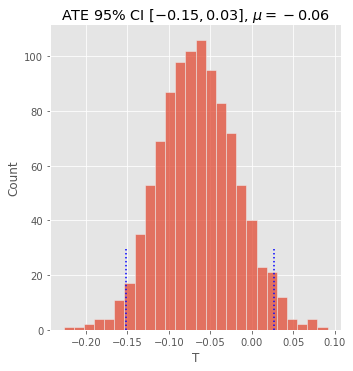

In [21]:
fg = sns.displot(bootstrap_df['T'], kde=False)
_ = fg.ax.vlines(lower_ci, 0, 30, linestyles='dotted', color='blue')
_ = fg.ax.vlines(upper_ci, 0, 30, linestyles='dotted', color='blue')
_ = fg.ax.set_title(rf'ATE 95% CI $[{lower_ci:.2f}, {upper_ci:.2f}]$, $\mu={ate_mean:.2f}$')